# Section 1
A deck of slides for each section, preferably in *.pptx or &.pdf form

### Import libraries and dataset
---

In [289]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
#!pip install geopandas
import geopandas as gpd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

## Question 1 (Prediction)
---
Download the passing rate of annual vehicle inspection records from 
https://data.gov.sg/dataset/annual-motor-vehicle-inspection-passing-rate-of-motor-vehicles-on- first-inspection, and focus on inspections for motorcycles. 

In [5]:
#Import dataset
motor_df = pd.read_csv("annual-motor-vehicle-inspection-passing-rate-of-motor-vehicles-on-first-inspection.csv")
motor_df.isna().sum()

year               0
type               0
age                0
number_reported    0
number_passed      0
passing_rate       0
dtype: int64

### Task 1: 
What's the average passing rate on first inspection each year, taking into account motorcycles of all age groups?

In [10]:
#Find average for each year
motor_df[motor_df.type.eq('Motorcycles')].groupby('year').passing_rate.mean()

year
2006    92.990909
2007    93.686925
2008    93.870527
2009    93.873521
2010    93.981256
2011    94.045351
2012    92.791833
2013    89.050335
2014    83.116493
2015    86.459294
2016    87.506665
2017    87.604945
Name: passing_rate, dtype: float64

### Task 2: 
For motorcycles of each age, estimate their passing rate next year.

In [17]:
#Finding estimates via mean across all years
motor_df[motor_df.type.eq('Motorcycles')].groupby('age').passing_rate.mean()

age
1      63.456783
10     93.650926
2      93.747265
3      93.277411
4      93.699475
5      93.586574
6      93.564131
7      93.522407
8      93.458418
9      93.599726
>10    92.666765
Name: passing_rate, dtype: float64

### Task 3: 
Assuming your estimated rates are true, can you suggest a sensible range of possible passing ranges for motorcycles in the 5-year age group next year (2017), with at least 95% possibility of including the actual passing rate? If you can come up with multiple ranges that meet this criteria, use the one with the narrowest range. You may assume the number of motorcycles is the same as the number in the 4-year age group in the previous year

In [27]:
motor_df_2017 = motor_df[motor_df.type.eq('Motorcycles') & motor_df.age.eq('5')]
st.t.interval(alpha=0.95, df=len(motor_df_2017['passing_rate'])-1, loc=np.mean(motor_df_2017['passing_rate']), scale=st.sem(motor_df_2017['passing_rate']))

(92.17143859428154, 95.00171006071847)

## Question 2 (Association)
---
Download the list of transactions by each property agent from https://data.gov.sg/dataset/cea-salesperson-residential-transaction-record, and focus on HDB resale flat transactions where a property agent represented the seller.

In [150]:
#Import dataset
agent_df = pd.read_csv("cea-salespersons-property-transaction-records-residential.csv", dtype={'district': str})
agent_df.replace('-', np.nan, inplace=True)

### Task 1: 
Based on the dataset, how many sales would you expect an agent to close each year? How 
much variation is there among agents?

In [162]:
#Assume rows with blank salesperson_name are still legitimate transactions
agent_df['transaction_year']= agent_df.transaction_date.str[-4:]
year_count = len(agent_df.transaction_year.dropna().unique())
agent_count = len(agent_df.salesperson_name.dropna().unique())
mean_sales_count = (agent_df.shape[0]/year_count)/agent_count
mean_sales_count

1.2823290304376962

In [67]:
#Find variance among agents
mean_per_agent = agent_df.groupby(['salesperson_name']).salesperson_name.count()/len(agent_df.transaction_year.unique())
mean_per_agent.var()

6.039704725540728

### Task 2: 
Examine the distribution for number of sales closed by an agent in a year & suggest a 
probability distribution that may be suitable for modelling this set of values. What are some ways in which your suggested distribution is appropriate? What are some of its limitations?

c:\Users\HuiHong\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


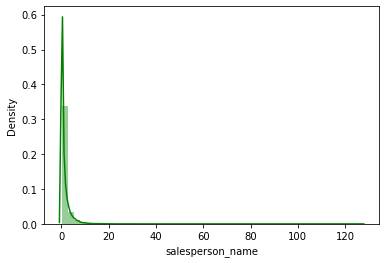

In [74]:
#Suggested probability distribution is exponential distribution
fig, ax = plt.subplots()
sns.distplot(mean_per_agent, color="g", ax=ax)
plt.show()

### Task 3:
Property agents tend to specialise in one or more specific geographical areas, rather than ply 
their trade equally island-wide. Given a property agent who has closed sales in Sembawang and 
Yishun during a given year, which other town is he/she most likely to be active in that year? <br/>
(Note: you may wish to use association rules for this task.)

In [135]:
#Group all towns each agent visited in a year into lists
temp = agent_df.dropna(subset=['town']).groupby(['salesperson_name', ]).town.apply(list)

#Remove duplicated towns
temp = list(temp.apply(lambda x: list(set(x))))

#Find areas most assocaited to YISHUN and SEMBAWANG
overall_items = []
for group in temp:
    if 'YISHUN' in group and 'SEMBAWANG' in group:
        associated_items = set(group) - {'YISHUN', 'SEMBAWANG'}
        overall_items += list(associated_items)
pd.Series(overall_items).value_counts().head(1) #most associated town is SengKang

SENGKANG    1475
dtype: int64

## Question 3 (Classification)
---
Download the Wireless@SG hotspots file from https://data.gov.sg/dataset/wireless-hotspots (in 
either KML or geoJSON format), and extract the data associated with it. You should obtain a table with over 1600 rows and several columns, where each row corresponding to a different WiFi hotspot in Singapore.

In [348]:
#Import dataset 
data = gpd.read_file('wireless-hotspots-geojson.geojson')
df_list = []

def get_df(df_list, value):
    temp = pd.read_html(str(value))
    temp_df = pd.DataFrame(temp[0]).set_index('Attributes').T.reset_index(drop=True)
    df_list.append(temp_df)

#Get data from Description column and then concat all data into df
data.Description.apply(lambda x: get_df(df_list,x))
wifi_df = pd.concat(df_list, axis=0).reset_index(drop=True)
wifi_df.columns.name = None #remove column index label

### Task 1: 
From the table, what are some of the information you can deduce for each hotspot? 

In [349]:
#Information includes X, Y coordinates, location name and type, postal code, street address and operator name
wifi_df.head(5)

,Y,X,LOCATION_NAME,LOCATION_TYPE,POSTAL_CODE,STREET_ADDRESS,OPERATOR_NAME,INC_CRC,FMEL_UPD_D
0,36922.92412,18450.95232,Bukit Batok CC,Community,659959,21 Bukit Batok Central,M1,9BB55356462956EF,20200318162531
1,45530.46595,28308.65184,1 Northpoint Drive,Community,768019,1 Northpoint Drive,M1,BD725D1716D3959C,20200318162531
2,31394.65632,30187.62071,155 Waterloo St,Government,187962,155 Waterloo Street,M1,05EF8371C69FD210,20200318162531
3,29861.29437,29464.67939,20 Upper Pickering St,Community,058284,20 Upper Pickering Street,M1,AD6A8E558E96E20B,20200318162531
4,42345.17715,34269.36498,7 Star Canteen,F&B,540338,338 Anchorvale Crescent,M1,67FF233DF9721356,20200318162531


### Task 2:
Due to a system error, the location type column for the last 200 rows of the dataset has 
become garbled. Using all earlier rows as well as all other columns in the dataset, build a 
classification model to predict the location type for these hotspots. You may treat the three rarest location types as one category. <br/>
(Note: you may wish to create some additional features based on available ones.)

In [350]:
#Prepare data
#Check rarest locations
wifi_df.LOCATION_TYPE.value_counts()

#Combine rarest location to 'Others'
wifi_df['LOCATION_TYPE'] = np.where(wifi_df.LOCATION_TYPE.isin(['Tourist Attraction', 'Dormitory / Care Centre', 'Public Worship']), 'Others', wifi_df.LOCATION_TYPE)

#Get dummy variables for categorical variables
df_cleaned = pd.get_dummies(wifi_df, columns=['LOCATION_NAME', 'STREET_ADDRESS', 'OPERATOR_NAME'], prefix_sep='')

#Creating dependent variable
df_cleaned['DEPENDENT'] = pd.factorize(df_cleaned['LOCATION_TYPE'])[0]

In [351]:
#Get train test set

train_x = df_cleaned.iloc[:-200,:].drop(columns=['LOCATION_TYPE', 'INC_CRC', 'FMEL_UPD_D'])
train_y = df_cleaned.iloc[:-200,:].DEPENDENT
test_x = df_cleaned.iloc[-200:,:].drop(columns=['LOCATION_TYPE', 'INC_CRC', 'FMEL_UPD_D'])
test_y = df_cleaned.iloc[-200:,:].DEPENDENT

#Instantiate model with 1000 decision trees
model = RandomForestClassifier(n_estimators = 1000, random_state = 2022)

#Train the model on training data
model.fit(train_x, train_y)

#Use the forest's predict method on the test data
pred_y = model.predict(test_x)

### Task 3: 
The information has now been recovered from a backup copy of the file. Compared to the true location types, how good was your model? Be prepared to explain the metrics you use to evaluate your model.

In [352]:
#Evaluate the model
print(f"Accuracy on training set: {round(model.score(train_x, train_y)*100,2)}%")
print(f"Accuracy on test set: {round(model.score(test_x, test_y)*100,2)}%")

Accuracy on training set: 100.0%
Accuracy on test set: 67.5%


## Question 4 (Data Visualization)
---
A colleague is working with a salary dataset based on recent poly graduates in a specific course of study highly subsidised by the government, to compare whether the career choices made by students from Group X are different from those from Group Y in any manner. She has already produced the following summary table and listed out the main insight she wishes to highlight, as well as pertinent observations on the dataset’s characteristics, but is struggling to come up with a good way to communicate the insight to her audience in one visualisation while also accurately reflecting the dataset’s characteristics. 

### Main insight: 
It may be worth reviewing the policy behind subsidising this course of study, as a considerable proportion of students from each group do not go on to work in industries closely related to it. For Group X, this may be partially due to higher / comparable salaries offered by other industries. For Group Y, non-salary factors may play a more prominent role. 

### Data characteristics: 
1.  There are considerably more students from Group X than Group Y in this course of study. 
2.  Proportionately more students from Group Y are in jobs unrelated to their course of study. 
3.  The distribution of students among various industries is considerably different between the two student groups. 
4.  Students from Group X tend to command higher salaries, for the same type of job & industry. 
5.  The salary differential between the two student groups differs by job nature and industry.


### Task: 
Help your colleague present the insight in an intuitive manner that is easily understood by a 
non-technical audience, and that reflects as many characteristics in the list as possible. Be prepared to justify any and every aspect of your visualisation (e.g. chart choice, colour palette, labels, orientation, etc.)

In [ ]:
#Visualization